<a href="https://colab.research.google.com/github/javier-jaime/Stock_Price_Forecasting/blob/main/Update4_BTC_Price_Forecasting_with_yfinance_and_Facebook_Prophet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Bitcoin Price Forecasting with yfinance and Facebook Prophet**

## Importing all the necessary Libraries

In [1]:
!pip install yfinance
import yfinance as yf
import pandas as pd
import numpy as np
import plotly.express as px
from fbprophet import Prophet
import plotly.io as pio
pio.renderers.default='colab'

     |████████████████████████████████| 6.3 MB 7.9 MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.64-py2.py3-none-any.whl size=24109 sha256=88d6d1a2c5f8ffd7d288f754e0e522e07e6f26e97de4186829a6329903abb070
  Stored in directory: /root/.cache/pip/wheels/86/fe/9b/a4d3d78796b699e37065e5b6c27b75cff448ddb8b24943c288
Successfully built yfinance
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


## Importing the Dataset & Exploring it

In [2]:
# Stock Ticker Input
stock = input('Enter the stock ticker: ')
print(f'You entered {stock}, here is the data from the last 10 days:')
period = '3y'
ticker = yf.Ticker(stock)
data = ticker.history(period)
data.reset_index(inplace=True)
data.tail(10)

Enter the stock ticker: BTC-USD
You entered BTC-USD, here is the data from the last 10 days:


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
1083,2021-11-02,60963.253906,64242.792969,60673.054688,63226.402344,37746665647,0,0
1084,2021-11-03,63254.335938,63516.937500,61184.238281,62970.046875,36124731509,0,0
1085,2021-11-04,62941.804688,63123.289062,60799.664062,61452.230469,32615846901,0,0
1086,2021-11-05,61460.078125,62541.468750,60844.609375,61125.675781,30605102446,0,0
1087,2021-11-06,61068.875000,61590.683594,60163.781250,61527.480469,29094934221,0,0
1088,2021-11-07,61554.921875,63326.988281,61432.488281,63326.988281,24726754302,0,0
1089,2021-11-08,63344.066406,67673.742188,63344.066406,67566.828125,41125608330,0,0
1090,2021-11-09,67549.734375,68530.335938,66382.062500,66971.828125,42357991721,0,0
1091,2021-11-10,66953.335938,68789.625000,63208.113281,64995.230469,48730828378,0,0
1092,2021-11-11,64636.902344,65516.523438,64234.160156,64721.972656,45674438656,0,0


In [3]:
print('These are the basic stats:')
data.describe()

These are the basic stats:


,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,1093.000000,1093.000000,1093.000000,1093.000000,1.093000e+03,1093.0,1093.0
mean,19715.149902,20262.538562,19140.434221,19767.391923,3.071285e+10,0.0,0.0
std,18168.900144,18711.154144,17582.504911,18215.624638,2.119857e+10,0.0,0.0
min,3236.274658,3275.377930,3191.303467,3236.761719,3.551764e+09,0.0,0.0
25%,7561.795410,7781.867188,7460.756348,7569.629883,1.709751e+10,0.0,0.0
50%,10136.309570,10295.668945,9851.692383,10138.517578,2.663208e+10,0.0,0.0
75%,34013.613281,35038.535156,32584.667969,33992.429688,3.997748e+10,0.0,0.0
max,67549.734375,68789.625000,66382.062500,67566.828125,3.509679e+11,0.0,0.0


# Data Visualization (plotly express) - Visualizing the historical performance

In [4]:
#Line graph (Price), Area graph (Volume) , box plot (Analyzing price and volume)

In [5]:
px.line(data, x="Date", y="Close", title=f'{stock} Stock Close Price')

In [6]:
px.bar(data, x="Date", y="Volume", title=f'{stock} Stock Volume')

In [7]:
px.box(data, y="Close", title=f'{stock} box plot', height=500, width=500)

In [29]:
def get_hurst_exponent(time_series, max_lag=20):
    """Returns the Hurst Exponent of the time series"""
    lags = range(2, max_lag)
    # variances of the lagged differences
    tau = [np.std(np.subtract(time_series[lag:], time_series[:-lag])) for lag in lags]
    # calculate the slope of the log plot -> the Hurst Exponent
    reg = np.polyfit(np.log(lags), np.log(tau), 1)
    return reg[0]

In [30]:
get_hurst_exponent(data["Close"].values)

0.5343297208382161

In [70]:
hurst = pd.DataFrame(columns =["hurst_exp","lag"])
lags = range(8, 65, 2)
for lag in lags:
    hurst_exp = get_hurst_exponent(data["Close"].values, lag)
    hurst = hurst.append({"hurst_exp":hurst_exp,"lag":lag},ignore_index=True)
px.line(hurst, x="hurst_exp", y="lag", title=f'{stock} Hurst Exp')

## Data Preparation for Facebook Prophet

In [10]:
columns=['Date','Close']
prophet_df=pd.DataFrame(data,columns=columns)
prophet_df= prophet_df.rename(columns={'Date':'ds','Close':'y'})  
prophet_df.tail()

,ds,y
1088,2021-11-07,63326.988281
1089,2021-11-08,67566.828125
1090,2021-11-09,66971.828125
1091,2021-11-10,64995.230469
1092,2021-11-11,64721.972656


## Creating Facebook Prophet Model

In [19]:
m=Prophet(daily_seasonality=False)
m.fit(prophet_df)

##Forecasting

In [20]:
periods = 30
future=m.make_future_dataframe(periods)

In [21]:
forecast=m.predict(future)

In [22]:
forecast.head(10)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-11-11,5319.949616,2242.995958,9020.199499,5319.949616,5319.949616,194.781808,194.781808,194.781808,-16.032152,-16.032152,-16.032152,210.813960,210.813960,210.813960,0.0,0.0,0.0,5514.731424
1,2018-11-12,5191.597722,2106.689077,9010.710899,5191.597722,5191.597722,290.900286,290.900286,290.900286,22.560267,22.560267,22.560267,268.340019,268.340019,268.340019,0.0,0.0,0.0,5482.498008
2,2018-11-13,5063.245827,1610.811882,8857.729780,5063.245827,5063.245827,276.670558,276.670558,276.670558,-54.150439,-54.150439,-54.150439,330.820997,330.820997,330.820997,0.0,0.0,0.0,5339.916386
3,2018-11-14,4934.893933,2138.292442,8911.151442,4934.893933,4934.893933,423.161808,423.161808,423.161808,25.745614,25.745614,25.745614,397.416194,397.416194,397.416194,0.0,0.0,0.0,5358.055741
4,2018-11-15,4806.542038,1692.922419,8595.240566,4806.542038,4806.542038,404.475806,404.475806,404.475806,-62.535825,-62.535825,-62.535825,467.011630,467.011630,467.011630,0.0,0.0,0.0,5211.017844
5,2018-11-16,4678.190144,2083.334600,9114.225877,4678.190144,4678.190144,599.002372,599.002372,599.002372,60.740702,60.740702,60.740702,538.261670,538.261670,538.261670,0.0,0.0,0.0,5277.192516
6,2018-11-17,4549.838249,1542.362961,8721.280735,4549.838249,4549.838249,633.309759,633.309759,633.309759,23.671834,23.671834,23.671834,609.637925,609.637925,609.637925,0.0,0.0,0.0,5183.148008
7,2018-11-18,4421.486355,1608.192269,8647.427723,4421.486355,4421.486355,663.451994,663.451994,663.451994,-16.032152,-16.032152,-16.032152,679.484146,679.484146,679.484146,0.0,0.0,0.0,5084.938348
8,2018-11-19,4293.134460,1685.730599,8657.328031,4293.134460,4293.134460,768.635901,768.635901,768.635901,22.560267,22.560267,22.560267,746.075635,746.075635,746.075635,0.0,0.0,0.0,5061.770361
9,2018-11-20,4164.782566,1489.208174,8515.872542,4164.782566,4164.782566,753.531126,753.531126,753.531126,-54.150439,-54.150439,-54.150439,807.681566,807.681566,807.681566,0.0,0.0,0.0,4918.313692


In [23]:
px.line(forecast, x='ds',y='yhat', title=f'{stock} Stock Forecast')

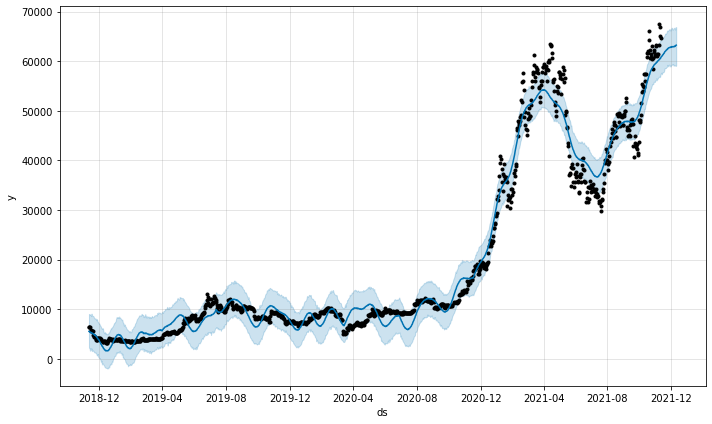

In [24]:
figure=m.plot(forecast, xlabel='ds', ylabel='y')

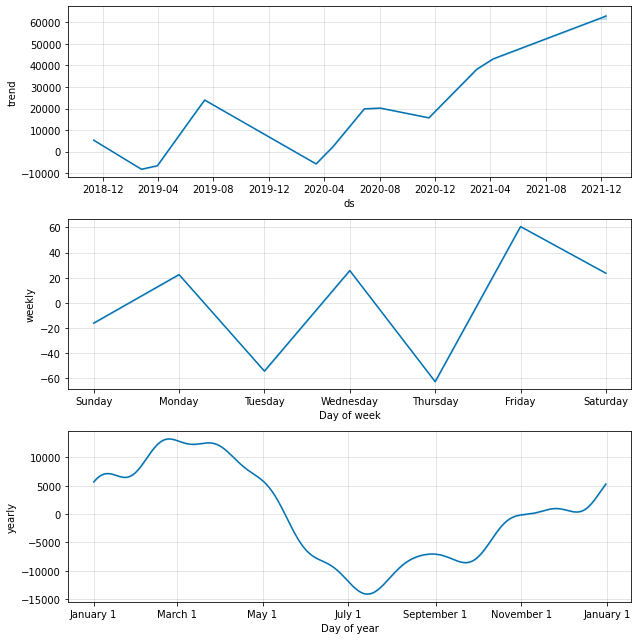

In [25]:
figure2=m.plot_components(forecast)

##Downloading the Forecast data

In [18]:
from google.colab import files
forecast.to_csv(f'{stock}_forecast.csv')
files.download(f'{stock}_forecast.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>